# Here I obtain overall team stats for entire seasons and visualize the correlation between different metrics and the number of regular season wins

# 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nba_api.stats.endpoints import leaguegamefinder, teamdashboardbygeneralsplits, playercareerstats
from nba_api.stats.endpoints import leagueleaders
from nba_api.stats.static import teams, players
import seaborn as sns

# 2. Obtaining, cleaning, and merging data to get team stats, league leaders, and season results

In [2]:
def clean_column_names(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('%', 'pct')
    return df

In [3]:
def get_games(seasons):
    gamefinder = leaguegamefinder.LeagueGameFinder()
    games = gamefinder.get_data_frames()[0]
    games['game_date'] = pd.to_datetime(games['GAME_DATE']) 
    games = games[games['game_date'].dt.year.isin(seasons)]  
    games = clean_column_names(games)  
    return games

In [4]:
def get_team_stats():
    team_list = teams.get_teams()  
    team_stats = [] 
    for team in team_list:
        team_dashboard = teamdashboardbygeneralsplits.TeamDashboardByGeneralSplits(team_id=team['id']) #
        team_df = team_dashboard.get_data_frames()[0] 
        team_df['team_name'] = team['full_name']  
        team_stats.append(clean_column_names(team_df))
    return pd.concat(team_stats, ignore_index=True)

In [5]:
def get_player_stats(season):
    player_list = players.get_players()
    player_stats = []
    for player in player_list[:50]:  
        try:
            player_career = playercareerstats.PlayerCareerStats(player_id=player['id'])
            player_df = player_career.get_data_frames()[0]
            player_df['player_name'] = player['full_name']  
            player_stats.append(clean_column_names(player_df))
        except Exception as e:
            print(f"Failed for {player['full_name']}: {e}")
    return pd.concat(player_stats, ignore_index=True)

In [6]:
def get_league_leaders(stat_category='PTS'):
    leaders = leagueleaders.LeagueLeaders(stat_category_abbreviation=stat_category)
    leader_data = leaders.get_data_frames()[0]
    return clean_column_names(leader_data)

# 3. Saving data to a csv and then loading it in

In [7]:
def combine_data(seasons):
    games = get_games(seasons)
    team_stats = get_team_stats()
    player_stats = get_player_stats(season=max(seasons))
    league_leaders = get_league_leaders()
    
    games.to_csv('../data/games_cleaned.csv', index=False)
    team_stats.to_csv('../data/team_stats_cleaned.csv', index=False)
    player_stats.to_csv('../data/player_stats_cleaned.csv', index=False)
    league_leaders.to_csv('../data/league_leaders_cleaned.csv', index=False)
    
    return games, team_stats, player_stats, league_leaders

In [8]:
league_leaders = pd.read_csv('../data/league_leaders_cleaned.csv')
player_stats = pd.read_csv('../data/player_stats_cleaned.csv')
team_stats = pd.read_csv('../data/team_stats_cleaned.csv')
games = pd.read_csv('../data/games_cleaned.csv') 

# 4. Splitting data into "winning" and "losing" teams and finding descriptive statistics for each group

In [9]:
winning_teams = team_stats[team_stats['w_pct'] > 0.5]
losing_teams = team_stats[team_stats['w_pct'] < 0.5]

winning_stats = winning_teams[['pts', 'plus_minus', 'reb', 'ast', 'tov']].describe()
losing_stats = losing_teams[['pts', 'plus_minus', 'reb', 'ast', 'tov']].describe()

In [10]:
winning_teams['to_assist_ratio'] = winning_teams['tov'] / winning_teams['ast']
losing_teams['to_assist_ratio'] = losing_teams['tov'] / losing_teams['ast']

winning_teams['reb_points_ratio'] = winning_teams['reb'] / winning_teams['pts']
losing_teams['reb_points_ratio'] = losing_teams['reb'] / losing_teams['pts']

/var/folders/fg/_cm9z0lx34b9zrpmj_h8s3q80000gn/T/ipykernel_69850/1822286465.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winning_teams['to_assist_ratio'] = winning_teams['tov'] / winning_teams['ast']
/var/folders/fg/_cm9z0lx34b9zrpmj_h8s3q80000gn/T/ipykernel_69850/1822286465.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  losing_teams['to_assist_ratio'] = losing_teams['tov'] / losing_teams['ast']
/var/folders/fg/_cm9z0lx34b9zrpmj_h8s3q80000gn/T/ipykernel_69850/1822286465.py:4: SettingWithCopyWarn

# 5. Using Matplotlib to visualize correlations b/w season metrics and results

## 5a. Histograms

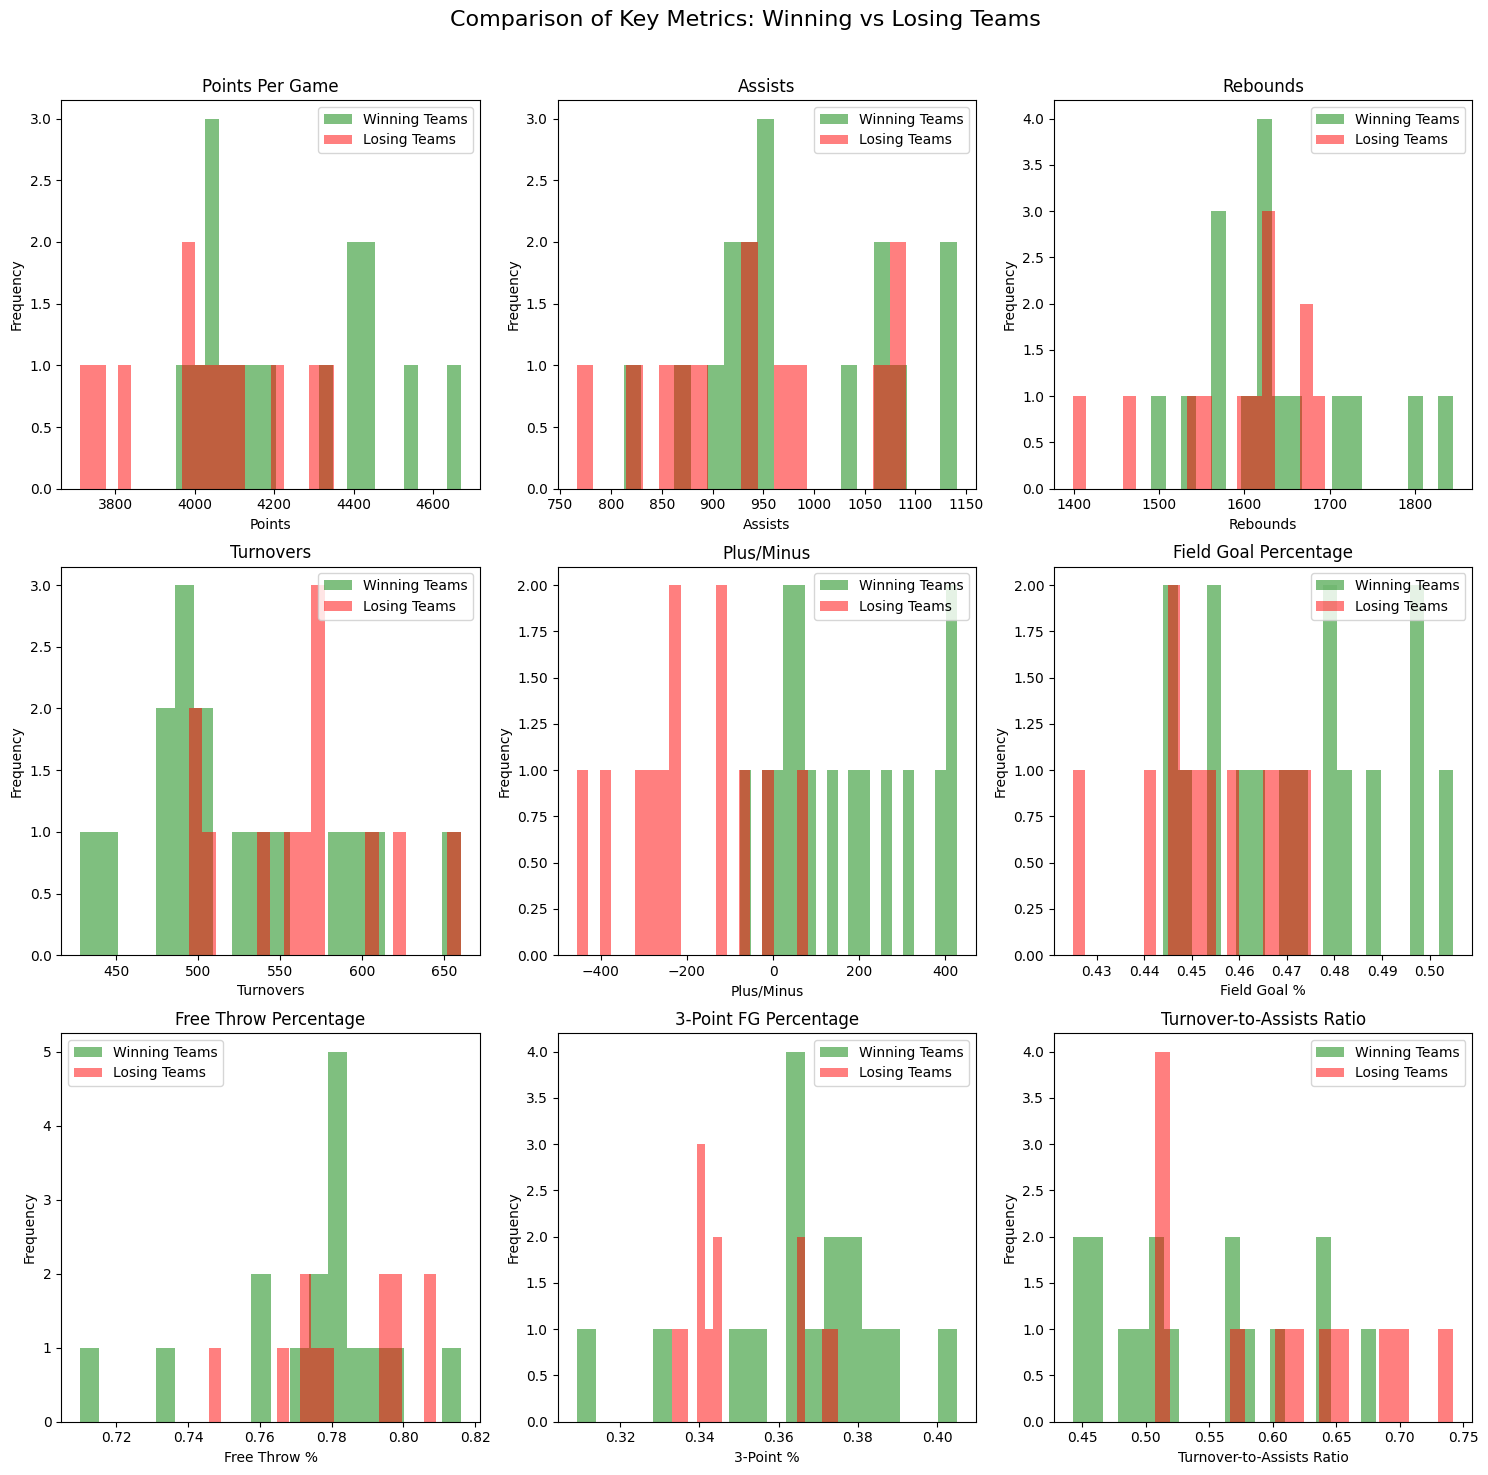

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Comparison of Key Metrics: Winning vs Losing Teams', fontsize=16)

# Points per game histogram
axes[0, 0].hist(winning_teams['pts'], bins=20, alpha=0.5, label='Winning Teams', color='green')
axes[0, 0].hist(losing_teams['pts'], bins=20, alpha=0.5, label='Losing Teams', color='red')
axes[0, 0].set_title('Points Per Game')
axes[0, 0].set_xlabel('Points')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Assists histogram
axes[0, 1].hist(winning_teams['ast'], bins=20, alpha=0.5, label='Winning Teams', color='green')
axes[0, 1].hist(losing_teams['ast'], bins=20, alpha=0.5, label='Losing Teams', color='red')
axes[0, 1].set_title('Assists')
axes[0, 1].set_xlabel('Assists')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Rebounds histogram 
axes[0, 2].hist(winning_teams['reb'], bins=20, alpha=0.5, label='Winning Teams', color='green')
axes[0, 2].hist(losing_teams['reb'], bins=20, alpha=0.5, label='Losing Teams', color='red')
axes[0, 2].set_title('Rebounds')
axes[0, 2].set_xlabel('Rebounds')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].legend()

# Turnovers histogram
axes[1, 0].hist(winning_teams['tov'], bins=20, alpha=0.5, label='Winning Teams', color='green')
axes[1, 0].hist(losing_teams['tov'], bins=20, alpha=0.5, label='Losing Teams', color='red')
axes[1, 0].set_title('Turnovers')
axes[1, 0].set_xlabel('Turnovers')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# Plus/Minus histogram 
axes[1, 1].hist(winning_teams['plus_minus'], bins=20, alpha=0.5, label='Winning Teams', color='green')
axes[1, 1].hist(losing_teams['plus_minus'], bins=20, alpha=0.5, label='Losing Teams', color='red')
axes[1, 1].set_title('Plus/Minus')
axes[1, 1].set_xlabel('Plus/Minus')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

# Field goal % histogram 
axes[1, 2].hist(winning_teams['fg_pct'], bins=20, alpha=0.5, label='Winning Teams', color='green')
axes[1, 2].hist(losing_teams['fg_pct'], bins=20, alpha=0.5, label='Losing Teams', color='red')
axes[1, 2].set_title('Field Goal Percentage')
axes[1, 2].set_xlabel('Field Goal %')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].legend()

#Free throw % histogrm 
axes[2, 0].hist(winning_teams['ft_pct'], bins=20, alpha=0.5, label='Winning Teams', color='green')
axes[2, 0].hist(losing_teams['ft_pct'], bins=20, alpha=0.5, label='Losing Teams', color='red')
axes[2, 0].set_title('Free Throw Percentage')
axes[2, 0].set_xlabel('Free Throw %')
axes[2, 0].set_ylabel('Frequency')
axes[2, 0].legend()

# 3-point  % histogrm 
axes[2, 1].hist(winning_teams['fg3_pct'], bins=20, alpha=0.5, label='Winning Teams', color='green')
axes[2, 1].hist(losing_teams['fg3_pct'], bins=20, alpha=0.5, label='Losing Teams', color='red')
axes[2, 1].set_title('3-Point FG Percentage')
axes[2, 1].set_xlabel('3-Point %')
axes[2, 1].set_ylabel('Frequency')
axes[2, 1].legend()

# Tov-Ast ratio histogram
axes[2, 2].hist(winning_teams['to_assist_ratio'], bins=20, alpha=0.5, label='Winning Teams', color='green')
axes[2, 2].hist(losing_teams['to_assist_ratio'], bins=20, alpha=0.5, label='Losing Teams', color='red')
axes[2, 2].set_title('Turnover-to-Assists Ratio')
axes[2, 2].set_xlabel('Turnover-to-Assists Ratio')
axes[2, 2].set_ylabel('Frequency')
axes[2, 2].legend()

# adjusting the layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)  
plt.show()



## 5b. Correlation heatmaps

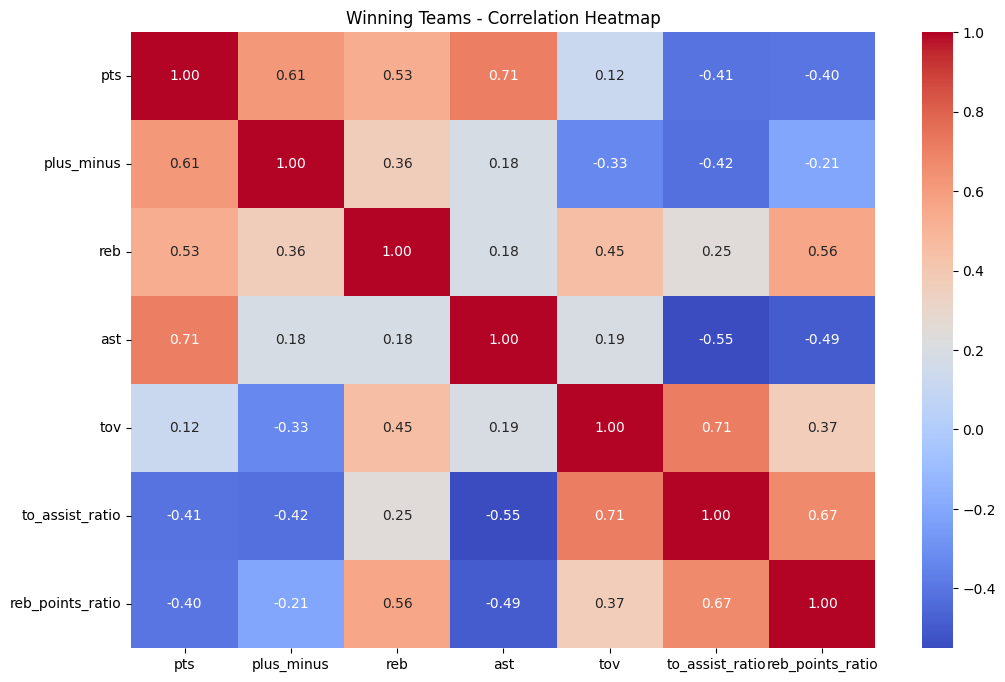

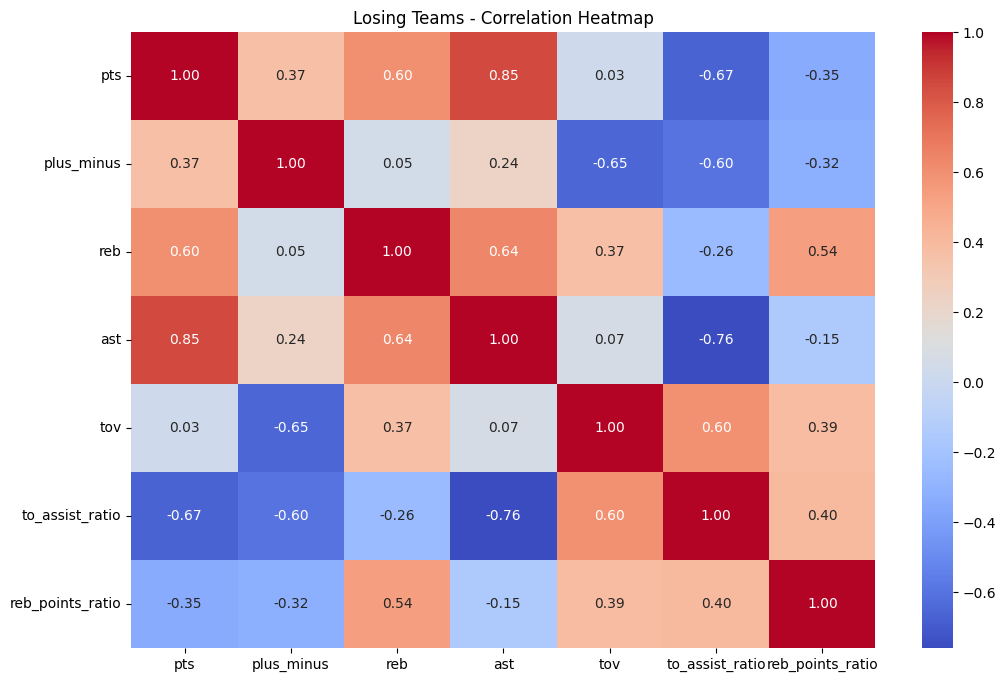

In [12]:
winning_teams_corr = winning_teams[['pts', 'plus_minus', 'reb', 'ast', 'tov', 'to_assist_ratio', 'reb_points_ratio']].corr()
losing_teams_corr = losing_teams[['pts', 'plus_minus', 'reb', 'ast', 'tov', 'to_assist_ratio', 'reb_points_ratio']].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(winning_teams_corr, annot=True, cmap='coolwarm', fmt='.2f') 
plt.title('Winning Teams - Correlation Heatmap')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(losing_teams_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Losing Teams - Correlation Heatmap')
plt.show()

## 5c. Scatterplots

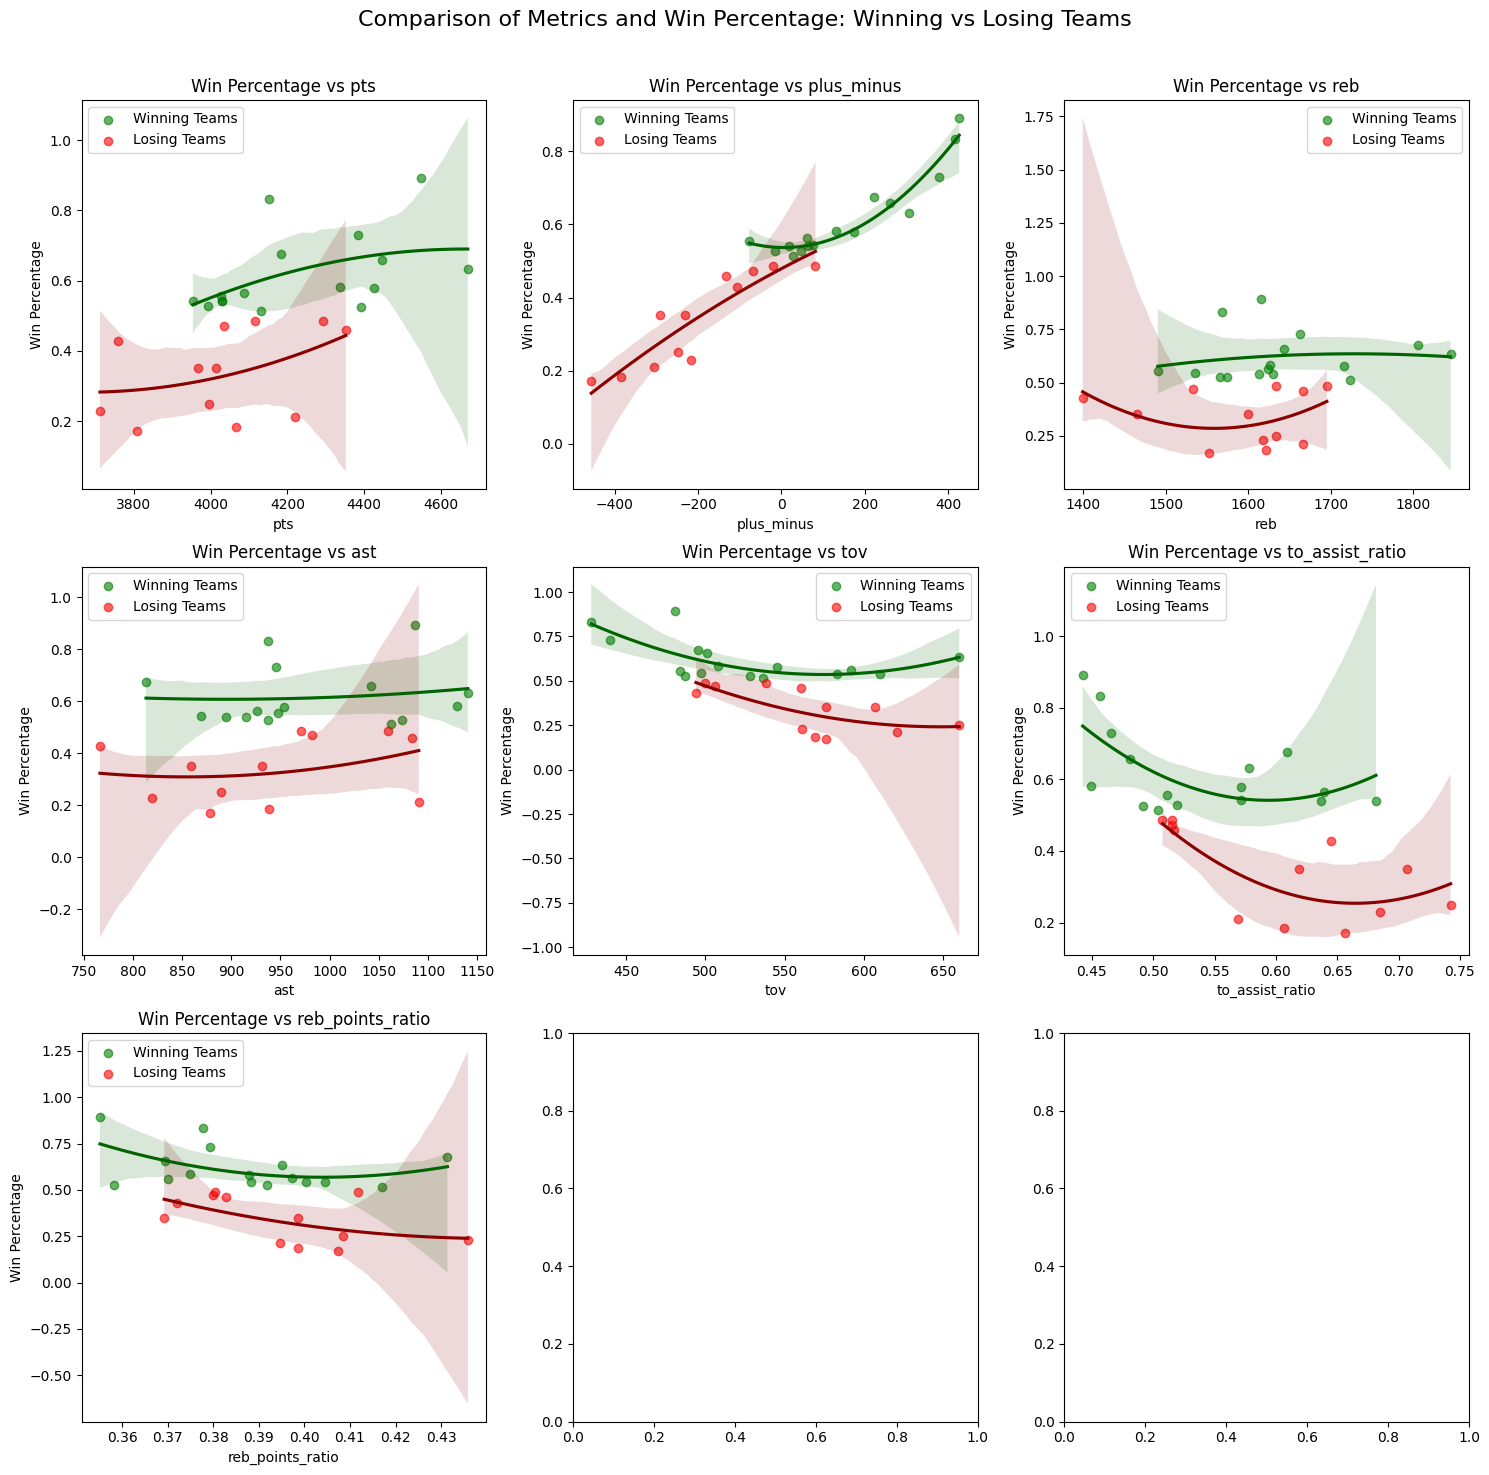

In [13]:
features = ['pts', 'plus_minus', 'reb', 'ast', 'tov', 'to_assist_ratio', 'reb_points_ratio']

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Comparison of Metrics and Win Percentage: Winning vs Losing Teams', fontsize=16)

for i, feature in enumerate(features):
    row = i // 3 
    col = i % 3  


    sns.regplot(x=feature, y="w_pct", data=winning_teams, ax=axes[row, col], 
                scatter_kws={'color': 'green', 'alpha': 0.6}, line_kws={'color': 'darkgreen'}, 
                label='Winning Teams', order=2) 


    sns.regplot(x=feature, y="w_pct", data=losing_teams, ax=axes[row, col], 
                scatter_kws={'color': 'red', 'alpha': 0.6}, line_kws={'color': 'darkred'}, 
                label='Losing Teams', order=2) 

    axes[row, col].set_title(f'Win Percentage vs {feature}')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Win Percentage')

    axes[row, col].legend()

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()
